# Heart Disease Risk Assessment using Bayesian Networks

### Authors: Matteo Fasulo, Luca Tedeschini, Antonio Gravina, Luca babboni

### Course: Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna

### Overview

**Cardiovascular diseases** (CVDs) are the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 32% of all deaths worldwide. Four out of 5 CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [[1]](#1). 

The main risk factors for **heart disease** are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects may include raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity [[1]](#1). Since the 1930s, research has identified diverse **CVD risk factors** [[2]](#2). Notably, the World Health Organization categorizes factors as modifiable (influenced by lifestyle) and non-modifiable [[3]](#3). Interestingly, modifiable factors can be significantly impacted by individual choices and interventions. 

In this notebook, we will use a **Bayesian Network** to assess the **risk of heart disease** in a patient based on these risk factors. We will face the modelling of **causal relations** between the risk factors and the disease, and we will use the network to make **predictions** about the risk of heart disease in a patient. The aim is to learn a model which **given** the risk factors of a patient as input (**evidence**), can predict the probability of the patient having heart disease. The causal relations between the risk factors and the disease will be both learned from data and from **domain knowledge** found in the **literature** and in **medical guidelines**.

The work was inspired by a paper [[4]](#4) in which the authors used a Bayesian Network to assess the risk of heart disease in a patient. Their work guided us in the choice of the risk factors and in the structure of the network. However, we will use a different dataset and we will use a different approach to learn the parameters of the network.

# Libraries

In [257]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.independencies.Independencies import IndependenceAssertion
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *
from pgmpy.readwrite import XMLBIFWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from IPython.display import display, Markdown, Latex

# Preprocessing

The original dataset 

In [169]:
df = pd.read_csv(f'data{os.sep}heart.csv')
df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

In [170]:
df['Oldpeak'].describe()

count    746.000000
mean       0.901609
std        1.072861
min       -0.100000
25%        0.000000
50%        0.500000
75%        1.500000
max        6.200000
Name: Oldpeak, dtype: float64

In [171]:
df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

df['ExerciseAngina'] = df['ExerciseAngina'].apply(
    lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(
    lambda x: False if x == 0 else True)

df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)
df["Age"] = pd.cut(x=df["Age"], bins=[20, 30, 40, 50, 60, 70, 80], labels=[
                   "20-30", "30-40", "40-50", "50-60", "60-70", "70-80"])
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, np.Inf], labels=[
                         "normal", "high", "very-high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[
                           0, 200, 240, np.Inf], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.qcut(x=df["MaxHR"], q=4, labels=["low", "medium", "high", "very-high"])
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=[-np.Inf, 0.5, 1, 2, np.Inf], labels=[
                       "<=0.5", "0-5-1", "1-2", "2+"])

In [172]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,30-40,M,ATA,high,high,False,Normal,very-high,False,<=0.5,Up,False
1,40-50,F,NAP,very-high,optimal,False,Normal,high,False,0-5-1,Flat,True
2,30-40,M,ATA,high,high,False,ST,low,False,<=0.5,Up,False
3,40-50,F,ASY,high,borderline,False,Normal,low,True,1-2,Flat,True
4,50-60,M,NAP,very-high,optimal,False,Normal,low,False,<=0.5,Up,False


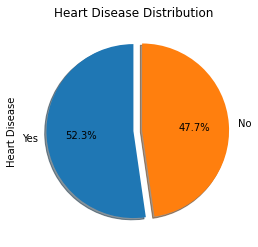

In [173]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[0, 0.1], shadow=True, labels=["Yes", "No"], label="Heart Disease", title="Heart Disease Distribution")
plt.show()

In [174]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Bayesian Network from Hill Climbing unconstrained

In [175]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore')

  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

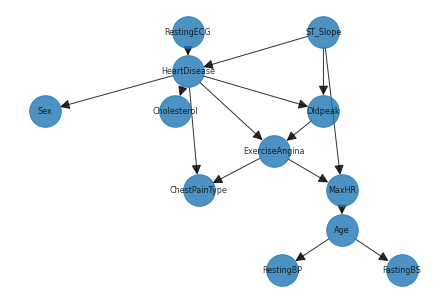

In [176]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

Ok, good but we want to express some edges and remove other with no causal meaning. We proceed to remove:
- HeartDisease -> Cholesterol
- Oldpeak -> HeartDisease
- ST_Slope -> HeartDisease
- ST_Slope -> MaxHR
- Nothing affects Age
- Nothing affects Sex

# Constrained

In [177]:
black_list = [(target_variable, 'Cholesterol'),
              ('Oldpeak', target_variable),
              ('ST_Slope', target_variable),
              ('ST_Slope', 'MaxHR'),
              ('ExerciseAngina', 'Cholesterol'),
              ('ST_Slope', 'Oldpeak'),
              ('ExerciseAngina', 'RestingECG'),
              ('ExerciseAngina', 'ChestPainType')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [178]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

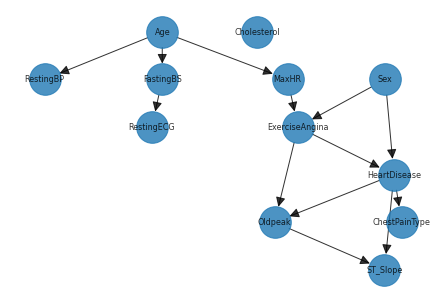

In [179]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [180]:
estimated_model.add_edge('Sex', 'Cholesterol')
estimated_model.add_edge('Cholesterol', target_variable)
estimated_model.add_edge('Oldpeak', 'ST_Slope')
estimated_model.add_edge('RestingECG', target_variable)
estimated_model.add_edge('RestingBP', target_variable)
estimated_model.add_edge('Cholesterol', 'RestingBP')
estimated_model.add_edge('FastingBS', target_variable)
estimated_model.add_edge('Age', 'Cholesterol')

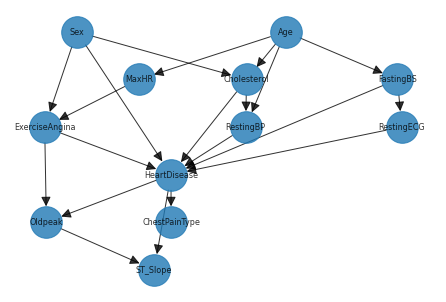

In [181]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [182]:
model = BayesianNetwork(estimated_model.edges())

In [183]:
model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
model.get_cpds()
assert model.check_model()

/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

In [184]:
if not os.path.isdir('model'):
    os.mkdir('model')
model.save(f'model{os.sep}heart_disease_model.bif')
writer = XMLBIFWriter(model)
writer.write_xmlbif(f'model{os.sep}heart_disease_model.xml')

In [185]:
y_pred = model.predict(X_test)
y_pred.head()

  0%|          | 0/111 [00:00<?, ?it/s]

,HeartDisease
0,True
1,False
2,True
3,False
4,True


In [186]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

0.7987220447284346

In [187]:
accuracy_score(y_test, y_pred[target_variable])

0.7857142857142857

# Domain Knowledge Network

In [188]:
final_model = BayesianNetwork([
    ('Age', 'Cholesterol'),
    ('Age', 'RestingECG'),
    ('Age', 'MaxHR'),
    ('Age', 'RestingBP'),
    ('Age', 'FastingBS'),
    ('Age', target_variable),
    ('Sex', 'Cholesterol'),
    ('Sex', 'MaxHR'),
    ('Sex', 'ExerciseAngina'),
    ('Sex', target_variable),
    ('RestingECG', target_variable),
    ('MaxHR', 'ExerciseAngina'),
    ('Cholesterol', target_variable),
    ('Cholesterol', 'RestingBP'),
    ('RestingBP', 'FastingBS'),
    ('FastingBS', target_variable),
    ('ExerciseAngina', target_variable),
    ('ExerciseAngina', 'Oldpeak'),
    ('ExerciseAngina', 'ST_Slope'),
    (target_variable, 'Oldpeak'),
    (target_variable, 'ST_Slope'),
    (target_variable, 'ChestPainType'),
    ('Oldpeak', 'ST_Slope'),
]
)

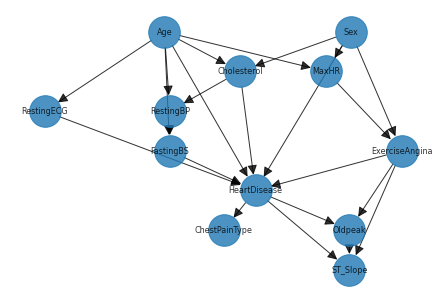

In [189]:
pos = nx.nx_agraph.graphviz_layout(final_model, prog="dot")
nx.draw(final_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [190]:
final_model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
final_model.get_cpds()
assert final_model.check_model()

/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/luca/.local/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

In [191]:
if not os.path.isdir('model'):
    os.mkdir('model')
final_model.save(f'model{os.sep}heart_disease_model.bif')
writer = XMLBIFWriter(final_model)
writer.write_xmlbif(f'model{os.sep}heart_disease_model.xml')

In [192]:
y_pred = final_model.predict(X_test)
y_pred.head()

  0%|          | 0/111 [00:00<?, ?it/s]

,HeartDisease
0,False
1,False
2,False
3,False
4,True


In [193]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

0.870253164556962

In [194]:
accuracy_score(y_test, y_pred[target_variable])

0.8482142857142857

# Network analysis

Thanks to pgmpy it is possible to investigate several **properties of the network**. In particular the interent is to find the **conditional independencies** and **active trails** with respect to some given evidence or to ask for the **Markov Blanket** of a node. 

In [195]:
print(f'There can be made {len(final_model.get_independencies().get_assertions())}',
      'valid independence assertions with respect to the all possible given evidence.')
print('For instance, any node in the network is independent of its non-descendents given its parents:\n',
      f'\n{model.local_independencies(df.columns.tolist())}\n')

print('But we can also find some other independencies in the network given some evidence. For example:\n')

for node in df.columns.tolist():
      for assertion in final_model.get_independencies(latex=False, include_latents=True).get_assertions(): 
            if node in  assertion.get_assertion()[0] and len(assertion.get_assertion()[2]) < 4 and len(assertion.get_assertion()[1]) < 3 and assertion not in model.local_independencies(df.columns.tolist()).get_assertions() :
                  print(assertion)
                  break

There can be made 9885 valid independence assertions with respect to the all possible given evidence.
For instance, any node in the network is independent of its non-descendents given its parents:
 
(Age ⟂ Sex)
(Sex ⟂ Age, MaxHR, RestingECG, FastingBS)
(ChestPainType ⟂ RestingECG, FastingBS, RestingBP, Cholesterol, ExerciseAngina, MaxHR, Age, Oldpeak, Sex, ST_Slope | HeartDisease)
(RestingBP ⟂ Sex, RestingECG, FastingBS, ExerciseAngina, MaxHR | Age, Cholesterol)
(Cholesterol ⟂ MaxHR, ExerciseAngina, RestingECG, FastingBS | Age, Sex)
(FastingBS ⟂ Sex, Cholesterol, RestingBP, ExerciseAngina, MaxHR | Age)
(RestingECG ⟂ Age, Sex, Cholesterol, RestingBP, ExerciseAngina, MaxHR | FastingBS)
(MaxHR ⟂ Sex, RestingECG, FastingBS, RestingBP, Cholesterol | Age)
(ExerciseAngina ⟂ Age, RestingECG, FastingBS, RestingBP, Cholesterol | Sex, MaxHR)
(Oldpeak ⟂ RestingECG, FastingBS, RestingBP, Cholesterol, ChestPainType, MaxHR, Age, Sex | HeartDisease, ExerciseAngina)
(ST_Slope ⟂ RestingECG, ChestPainTyp

In [196]:
print('Thanks to this library it is also possible to find automatically the Markov blanket of any node in the network.\n')

def markov_blanket(model, target_variable):
    return f"Markov blanket of \'{target_variable}\' is {model.get_markov_blanket(target_variable)}"

for column in df.columns:
    print(markov_blanket(final_model, column))

Thanks to this library it is also possible to find automatically the Markov blanket of any node in the network.

Markov blanket of 'Age' is ['RestingECG', 'FastingBS', 'RestingBP', 'Cholesterol', 'ExerciseAngina', 'MaxHR', 'Sex', 'HeartDisease']
Markov blanket of 'Sex' is ['RestingECG', 'Cholesterol', 'FastingBS', 'ExerciseAngina', 'MaxHR', 'Age', 'HeartDisease']
Markov blanket of 'ChestPainType' is ['HeartDisease']
Markov blanket of 'RestingBP' is ['Age', 'Cholesterol', 'FastingBS']
Markov blanket of 'Cholesterol' is ['RestingECG', 'RestingBP', 'FastingBS', 'ExerciseAngina', 'Age', 'Sex', 'HeartDisease']
Markov blanket of 'FastingBS' is ['RestingECG', 'Cholesterol', 'RestingBP', 'ExerciseAngina', 'Age', 'Sex', 'HeartDisease']
Markov blanket of 'RestingECG' is ['Cholesterol', 'FastingBS', 'ExerciseAngina', 'Age', 'Sex', 'HeartDisease']
Markov blanket of 'MaxHR' is ['Age', 'Sex', 'ExerciseAngina']
Markov blanket of 'ExerciseAngina' is ['RestingECG', 'Cholesterol', 'FastingBS', 'MaxHR', 

# Inferences

## How the combinations of evidences effect the prediction

Pgmpy also provides expose some methods to inference the model.

In the following chapter we are gonna inference the model in order to understand how the evidence effects the results of the models.

More specifically we are gonna explore how the following combination of evidences effect the prediction of the model:
- `Age` of the patient
- the combinations of `RestingBP` and `FastingBP` of the patient
- the combination of the `Cholesterol` and `Sex` of the patient

In [270]:
from itertools import combinations, product
target = ['HeartDisease']

def format_string(array):
    string = str(array[0])
    for item in array[1:]: 
        string += f', {item}'
    return string

def exact_inference(model, variables, evidence):
    inference = VariableElimination(model)
    return inference.query(variables=variables, evidence=evidence)

def create_dictionary(df, columns):
    dictionary = {}
    for column in columns:
        dictionary[column] = df[column].unique().tolist()
    return dictionary

def get_all_combinations(dictionary):
    if len(dictionary) == 1:
        return [{list(dictionary.keys())[0]: value} for value in dictionary[list(dictionary.keys())[0]]]
    res = []
    for k1, k2 in combinations(dictionary.keys(), 2):
        for v1, v2 in product(dictionary[k1], dictionary[k2]):
            res.append({k1: v1, k2: v2})
    return res

def he_prob_analysis(model, target, knowledge, df):
    res = pd.DataFrame(columns=knowledge + ["Prob"]) 
    if len(knowledge) == 1:
        print(f'How the {format_string(knowledge)} affects the {format_string(target)} probability?')
    else:
        print(f'How the compbination of the variables {format_string(knowledge)} affects the {format_string(target)} probability?')

    all_values = create_dictionary(df, knowledge)
    all_queries = get_all_combinations(all_values)

    for query in all_queries:
        result =  exact_inference(final_model, target, query)
        query["Prob"] = result.values[1]
        res.loc[len(res)] = query

    return res.sort_values(by=knowledge[0], ascending=False).reset_index(drop=True)

In [271]:
evidences = ["Age"]
he_prob_analysis(final_model, target, evidences, df)

How the Age affects the HeartDisease probability?


,Age,Prob
0,70-80,0.553979
1,60-70,0.629084
2,50-60,0.496784
3,40-50,0.370697
4,30-40,0.328926
5,20-30,0.371442


In [272]:
evidences = ['RestingBP', 'FastingBS']
he_prob_analysis(final_model, target, evidences, df)

How the compbination of the variables RestingBP, FastingBS affects the HeartDisease probability?


,RestingBP,FastingBS,Prob
0,very-high,False,0.498246
1,very-high,True,0.564139
2,normal,False,0.429784
3,normal,True,0.528070
4,high,False,0.455900
5,high,True,0.546908


In [273]:
evidences =  ['Cholesterol', 'Sex']
he_prob_analysis(final_model, target, evidences, df)

How the compbination of the variables Cholesterol, Sex affects the HeartDisease probability?


,Cholesterol,Sex,Prob
0,optimal,M,0.539036
1,optimal,F,0.283536
2,high,M,0.588787
3,high,F,0.281383
4,borderline,M,0.486222
5,borderline,F,0.199647


In [274]:
evidences = ['ST_Slope', 'Oldpeak']
he_prob_analysis(final_model, target, evidences, df)

How the compbination of the variables ST_Slope, Oldpeak affects the HeartDisease probability?


,ST_Slope,Oldpeak,Prob
0,Up,<=0.5,0.099781
1,Up,0-5-1,0.233666
2,Up,1-2,0.272192
3,Up,2+,0.663247
4,Flat,<=0.5,0.715048
5,Flat,0-5-1,0.674055
6,Flat,1-2,0.787253
7,Flat,2+,0.922911
8,Down,<=0.5,0.156691
9,Down,0-5-1,0.389132


## Practical use of the model

In this chapter, we delve into practical examples of interacting with the model. We explore various types of requests and how the model responds. Additionally, we introduce a new feature that dynamically suggests the next medical examination based on estimated heart health risks.

In [277]:
def prediction(model, query):
    labels = df.columns.tolist()
    labels.remove('HeartDisease')
    variables = []

    for label in labels:
        if label not in query.keys():
            variables.append(label)

    base_result = exact_inference(model, target, query)
    probs = base_result.values
    probs = np.round(probs * 100, 2)

    my_dict = {}
    for col in df.drop('HeartDisease', axis=1).columns:
        my_dict[col] = df[col].unique().tolist()
    exam_df = pd.DataFrame(columns=['exam', 'outcome', 'prob'])

    for var in variables:
        for val in my_dict[var]:
            query[var] = val
            result = exact_inference(model, target, query)
            exam_df.loc[len(exam_df)] = [var, val, round(result.values[1],2)]
            del query[var]

    exam_df.sort_values(by='prob', ascending=False,inplace=True)

    print(f'Given the evidence: ')
    for key, value in query.items():
        print(f'{key}: {value}')
    print()
    print(f'The probability of having a heart disease is {probs[1]}%')
    print('The next exam suggested are:')
    display(exam_df.head(3))

In [278]:
query = {'Age': '30-40', 'Sex': 'M', 'ChestPainType' : 'ATA'}

prediction(final_model, query)
print('-'*20)

print('Now we are going to test the model with a new query adding the result of the suggested exams.')
query['Oldpeak'] = '<=0.5'
prediction(final_model, query)
print('-'*20)

print('Now we are going to test the model with a new query adding the result of the suggested exams.')
query['ST_Slope'] = 'Flat'
prediction(final_model, query)

Given the evidence: 
Age: 30-40
Sex: M
ChestPainType: ATA

The probability of having a heart disease is 8.86%
The next exam suggested are:


,exam,outcome,prob
20,Oldpeak,2+,0.45
16,ExerciseAngina,True,0.31
22,ST_Slope,Flat,0.27


--------------------
Now we are going to test the model with a new query adding the result of the suggested exams.
Given the evidence: 
Age: 30-40
Sex: M
ChestPainType: ATA
Oldpeak: <=0.5

The probability of having a heart disease is 3.72%
The next exam suggested are:


,exam,outcome,prob
18,ST_Slope,Flat,0.23
16,ExerciseAngina,True,0.13
7,FastingBS,True,0.10


--------------------
Now we are going to test the model with a new query adding the result of the suggested exams.
Given the evidence: 
Age: 30-40
Sex: M
ChestPainType: ATA
Oldpeak: <=0.5
ST_Slope: Flat

The probability of having a heart disease is 23.08%
The next exam suggested are:


,exam,outcome,prob
7,FastingBS,True,0.43
16,ExerciseAngina,True,0.36
13,MaxHR,low,0.30


### References

<a id="1">[1]</a>
World Health Organization. (2024). Cardiovascular diseases (CVDs). <https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)>

<a id="2">[2]</a>
Mahmood, S. S., Levy, D., Vasan, R. S., & Wang, T. J. (2014). The Framingham Heart Study and the epidemiology of cardiovascular disease: a historical perspective. Lancet (London, England), 383(9921), 999–1008. <https://doi.org/10.1016/S0140-6736(13)61752-3>

<a id="3">[3]</a>
WHO CVD Risk Chart Working Group (2019). World Health Organization cardiovascular disease risk charts: revised models to estimate risk in 21 global regions. The Lancet. Global health, 7(10), e1332–e1345. <https://doi.org/10.1016/S2214-109X(19)30318-3>

<a id="4">[4]</a>
Ordovas, J.; Rios-Insua, D.; Santos-Lozano, A.; Lucia, A.; Torres, A.; Kosgodagan, A.; and Camacho, J. (2023). A bayesian network model for predicting cardiovascular risk. Computer Methods and Programs in Biomedicine. <https://doi.org/10.1016/j.cmpb.2023.107405>